In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import math
import itertools
import json

In [2]:
# generate a grid of layered nodes along circular arcs

long_sep   = 20   # longitudinal separation between layers along x-axis (m)
arc_sep    = 5    # desired separation in m between adacent nodes along the arc (approx)
th_spread  = 30   # degrees, on each side of zero heading from prev layer nodes
num_layers = 4

def gen_circ_grid(long_sep, arc_sep, th_spread, num_layers):
    
    nodes = [[(0,0,0)]]   # initialize with origin (current pos in car frame)
    th_spread_rad = th_spread/360*2*np.pi
    fan = 0

    for i in range(num_layers):
        layer = i + 1
        r = long_sep * layer
        layer_nodes = []

        # calculate expanded heading angle
        phi = th_spread_rad - np.arcsin((r-long_sep)*np.sin(np.pi - th_spread_rad)/r)
        fan = fan + phi

        th_sep = arc_sep / r   # angular separation between nodes in current layer, radians
        n_pts = np.ceil(2*fan / th_sep)
        ths = np.linspace(-fan, fan, n_pts)

        for th in ths:
            x = r * np.sin(th)
            y = r * np.cos(th)
            layer_nodes.append((x,y,th))
        nodes.append(layer_nodes)
    return nodes


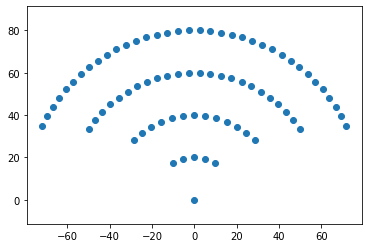

In [3]:
nodes = gen_circ_grid(long_sep, arc_sep, th_spread, num_layers)

# Plot
all_nodes = list(itertools.chain.from_iterable(nodes))
plt.scatter([x[0] for x in all_nodes],[x[1] for x in all_nodes])
plt.axis('equal');


In [6]:
# Generate all possible node combinations
# Depth-first walk through tree, taking only children nodes at each step that fall within th_spread range

def get_paths(nodes, layer=0, idx=0, parent=None, paths=None, current_path=None):
    if paths is None:
        paths = []
    if current_path is None:
        current_path = []
    
    cur_node = nodes[layer][idx]
    
    if parent is None:
        current_path.append(cur_node)
    else:   
        # Filter trajectories by allowable heading range
        r = long_sep * layer
        th_spread_rad = th_spread/360*2*np.pi
        phi = th_spread_rad - np.arcsin((r-long_sep)*np.sin(np.pi - th_spread_rad)/r)
        eps = 0.02
        th_rng = [parent[2] - phi - eps, parent[2] + phi + eps]
        if cur_node[2] >= th_rng[0] and cur_node[2] <= th_rng[1]:
            current_path.append(cur_node)
        else:
            return
        
    if len(nodes) == layer+1:
        paths.append(current_path)
    else:
        for idx in range(len(nodes[layer+1])):
            get_paths(nodes, layer+1, idx, cur_node, paths, list(current_path))
    return paths

In [7]:
paths = get_paths(nodes)
print('Number of paths: ', len(paths))
paths[0]

Number of paths:  580


[(0, 0, 0),
 (-9.999999999999998, 17.320508075688775, -0.5235987755982988),
 (-28.541019662496844, 28.025170768881473, -0.794517296054519),
 (-49.77225575051661, 33.50705235476804, -0.9782791621986959),
 (-71.92001400343489, 35.0358614243425, -1.1174811633013557)]

In [12]:
# Write a function to generate splines for each set of node paths
def gen_splines(paths):
    trajs = []
    long_sep = np.sqrt((paths[0][1][0]-paths[0][0][0])**2 + (paths[0][1][1]-paths[0][0][1])**2)
    
    for path in paths:
        x = np.array([p[0] for p in path])
        y = np.array([p[1] for p in path])

        init_heading = np.arccos(path[1][0]/long_sep)
        
        cx, cy = calc_c2_traj(x, y, init_heading)
        trajs.append((cx, cy))
    return trajs


trajs = gen_splines(paths)

In [13]:
# Evaluate all trajectories and save to json object

def eval_trajectories(paths, n_interps=100, outfile=None):
    
    splines = gen_splines(paths)

    eval_trajs = {}
    ts = np.linspace(0, len(paths[0])-1, n_interps)

    for i,traj in enumerate(splines):
        cx, cy = traj
        eval_trajs[i] = {'x': cx(ts).tolist(),
                         'y': cy(ts).tolist(),
                         'x_coef': cx.c.tolist(),  # spline coefficients array
                         'y_coef': cy.c.tolist()}
    
    if outfile is not None:
        with open(outfile, "w") as outfile:  
            json.dump(eval_trajs, outfile) 
    
    return eval_trajs



outfile = './traj_lib_example_v0.json'
eval_trajs = eval_trajectories(paths, outfile=outfile)


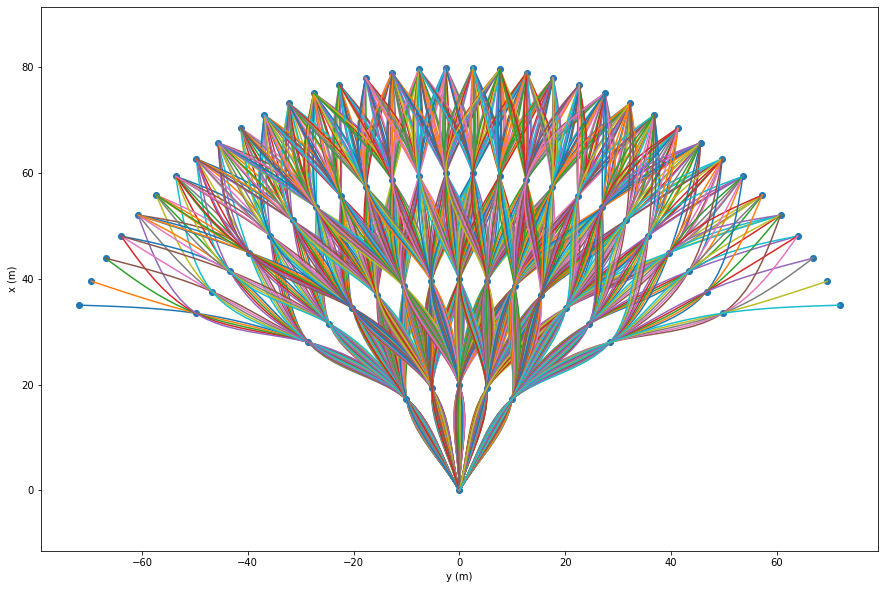

In [14]:
## PLOT all trajs
stepsize = 0.1
ts = np.arange(0, len(paths[0])-1+stepsize, stepsize)
ts_plus = np.arange(ts[0]-.5, ts[-1]+.3, stepsize)

plt.figure(figsize=(15,10))
plt.scatter([x[0] for x in all_nodes],[x[1] for x in all_nodes])
plt.axis('equal');
plt.xlabel('y (m)')
plt.ylabel('x (m)')

for traj in trajs:
    cx, cy = traj
    plt.plot(cx(ts), cy(ts))


In [15]:
ex_traj_pts = [n[0] for n in nodes]
ex_x = np.array([p[0] for p in ex_traj_pts])
ex_y = np.array([p[1] for p in ex_traj_pts])

init_heading = np.arccos(nodes[1][0][0]/long_sep) # leftmost node


In [16]:
cx, cy = calc_c2_traj(ex_x, ex_y, init_heading)

Text(0, 0.5, 'x (m)')

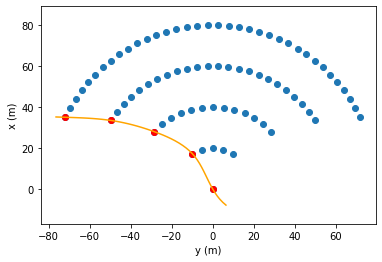

In [17]:
stepsize = 0.1
ts = np.arange(0, len(ex_x)-1+stepsize, stepsize)
ts_plus = np.arange(ts[0]-.5, ts[-1]+.3, stepsize)


plt.scatter([x[0] for x in all_nodes],[x[1] for x in all_nodes])
plt.scatter(ex_x, ex_y, color='red')
plt.axis('equal');
plt.plot(cx(ts_plus), cy(ts_plus), label='spline', color='orange')
plt.xlabel('y (m)')
plt.ylabel('x (m)')

In [18]:
def plot_trajectory(x, y, init_heading, cx, cy, stepsize=0.1):
    '''
    Plots x-y coords and cx(t)-cy(t) parametric spline
    Plots unit vectors showing the spline headings at boundaries
    Generates c1 and c2 plots showing heading and curvature continuity
    '''
    
    ts = np.arange(0, len(x)-1+stepsize, stepsize)
    ts_plus = np.arange(ts[0]-.2, ts[-1]+.3, stepsize)

#     # Heading constraint unit vectors
#     hvec_start = unitvec_from_heading(bch[0])
#     hvec_end = unitvec_from_heading(bch[-1])

    # Plot trajectory
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_ylim(min(y)-1, max(y)+1)
    ax.set_xlim(min(x)-2, max(x)+2)
    ax.plot(x, y, 'o', label= 'nodes')
    ax.plot(cx(ts_plus), cy(ts_plus), label='spline')
#     ax.annotate("", xy=(x[0] + hvec_start[0], y[0] + hvec_start[1]), xytext=(x[0], y[0]), arrowprops=dict(arrowstyle="->", color="red"))
#     ax.annotate("", xy=(x[-1] + hvec_end[0], y[-1] + hvec_end[1]), xytext=(x[-1], y[-1]), arrowprops=dict(arrowstyle="->", color="red"))
    ax.set_aspect('equal')
    ax.set_title('C2 trajectory')
    ax.set_xlabel('x(mu)')
    ax.set_ylabel('y(mu)')
    
    # Plot heading and curvature
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title('X(mu)')
    ax[0].plot(ts, cx(ts,1), label='Heading')
    ax[0].plot(ts, cx(ts,2), label='Curvature')
    ax[0].set_xlabel('mu')
    ax[0].legend()
    ax[1].set_title('Y(mu)')
    ax[1].plot(ts, cy(ts,1), label='Heading')
    ax[1].plot(ts, cy(ts,2), label='Curvature')
    ax[1].set_xlabel('mu')
    ax[1].legend()

In [ ]:
plot_trajectory(ex_x, ex_y, init_heading, cx, cy)

In [9]:
def gen_c2_spline(x, y, init_heading, slen_start, slen_end):
    '''
    Generates a C2 continuous spline using scipy CubicSpline lib
    x: np.array of x-coordinate points
    y: np.array of y-coordinate points
    '''
    
    # define mu, a virtual path variable of length 1 for each spline segment
    assert(len(x) == len(y))
    mu = np.arange(0,len(x), 1.0)

    # build splines
    cs_x = CubicSpline(mu, x, 
                   bc_type=((1, slen_start * np.cos(init_heading)), 
                            (2, 0.0)))
    cs_y = CubicSpline(mu, y, 
                   bc_type=((1, slen_start * np.sin(init_heading)), 
                            (2, 0.0)))
    return cs_x, cs_y

In [10]:
def calc_c2_traj(x, y, init_heading, eps = 0.005):
    '''
    Iteratively compute spline coefficients until spline length of first and last segment converges
    '''

    # Start with euclidean dist as slen approx for first and last segments
    slen_start = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    slen_end = np.sqrt((x[-1] - x[-2])**2 + (y[-1] - y[-2])**2)
#     print(slen_start, slen_end)

    while True:
        cx, cy = gen_c2_spline(x, y, init_heading, slen_start, slen_end)
        coeffs_x_start = np.flip(cx.c[:,0])
        coeffs_y_start = np.flip(cy.c[:,0])
        coeffs_x_end = np.flip(cx.c[:,-1])
        coeffs_y_end = np.flip(cy.c[:,-1])

        slen_start_new = calc_spline_length(coeffs_x_start, coeffs_y_start)
        slen_end_new = calc_spline_length(coeffs_x_end, coeffs_y_end)
#         print(slen_start_new, slen_end_new)

        if abs(slen_start_new - slen_start) < eps and abs(slen_end_new - slen_end) < eps:
            break
        else:
            slen_start = slen_start_new
            slen_end = slen_end_new
    return cx, cy

In [11]:
# Compute the first and last segment path lengths
def calc_spline_length(x_coeffs, y_coeffs, n_ips=20):
    '''
    Returns numerically computed length along cubic spline
    x_coeffs: array of 4 x coefficients
    y_coeffs: array of 4 y coefficients
    '''
    
    t_steps = np.linspace(0.0, 1.0, n_ips)
    spl_coords = np.zeros((n_ips, 2))
    
    spl_coords[:,0] = x_coeffs[0] \
                        + x_coeffs[1] * t_steps \
                        + x_coeffs[2] * np.power(t_steps, 2) \
                        + x_coeffs[3] * np.power(t_steps, 3)
    spl_coords[:,1] = y_coeffs[0] \
                        + y_coeffs[1] * t_steps \
                        + y_coeffs[2] * np.power(t_steps, 2) \
                        + y_coeffs[3] * np.power(t_steps, 3)
        
    slength = np.sum(np.sqrt(np.sum(np.power(np.diff(spl_coords, axis=0), 2), axis=1)))
    return slength